In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_sin_data(num_training, num_testing, std_noise=0.1):
    X_train = np.random.uniform(-1.5, 1.5, num_training)
    Y_train = np.sin(np.pi * X_train) + np.random.randn(num_training) * std_noise
    X_train = np.reshape(X_train, [num_training, 1])
    Y_train = np.reshape(Y_train, [num_training, 1])

    X_test = np.linspace(-2., 2., num_testing)[:, None]

    return X_train, Y_train, X_test

In [3]:
import sys 
sys.path.append("..") 
import tensorflow as tf

from dgp import DGP_RF
from likelihoods import Gaussian


class ToyRegressionDGP(DGP_RF):
    def __init__(self, d_in, d_out, n_hidden_layers=1, n_rf=20, n_gp=2, likelihood=Gaussian(),
                 kernel_list=None, random_fixed=True, name=None):
        super(ToyRegressionDGP, self).__init__(d_in, d_out, n_hidden_layers=n_hidden_layers,
                                            n_rf=n_rf, n_gp=n_gp,
                                            likelihood=likelihood, kernel_list=kernel_list,
                                            random_fixed=random_fixed, name=name)

    def feed_forward(self, X):
        X = tf.constant(X, tf.float32)
        # output mean because of the Gaussian likelihood in the final layer
        out = self.BNN(X)
        return out
    
    def feed_forward_all_layers(self, X):
        X = tf.constant(X, dtype=tf.float32)
        output_list = []
        for l, layer in enumerate(self.BNN.layers):
            X = layer(X)
            if l % 2 == 1:
                output_list.append(X)
        return output_list

    def adjust_traditional_learning_rate(self, epoch, lr_0=0.1, dtype=tf.float32):
        epoch = tf.cast(epoch, dtype)
        lr = lr_0
#         lr = 0.5 * (1. + epoch) ** (-0.5) * lr_0
        return lr

    def adjust_cyclical_learning_rate(self, k, K, M=1, lr_0=0.1):
        """
        using cyclical lr schedule
        :param k: current iteration index
        :param K: total iterations
        :param M: Number of cycles
        :param lr_0: initial learning rate
        """
        cos_inner = tf.constant(np.pi) / (K // M) * (k % (K // M))
        cos_out = tf.math.cos(cos_inner) + 1
        lr = 0.5 * lr_0 * cos_out
        return lr

Metal device set to: Apple M1 Pro


2022-06-10 19:10:27.392384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 19:10:27.392522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# traditional 1-layer DGPs 

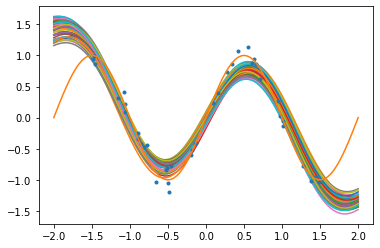

In [4]:
num_training = 40
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=50, n_gp=1, likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 300
num_samples = 50
eta = 0.9

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward(X_test)
        out_samples.append(out)

out_samples = tf.concat(out_samples, axis=-1).numpy() #[N, num_samples]
# print(out_samples)


plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))
# plt.savefig("sin-1-layer.png")

# cyclical stepsize - 1-layer DGPs

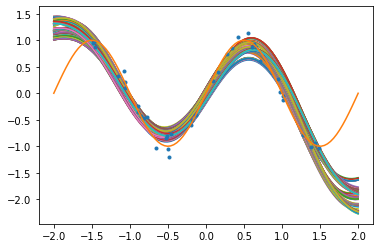

In [5]:
num_mixing_epoches = 0
num_cyclical_epoches = 500
eta = 0.9
M = 10
iteration_per_cycle = num_cyclical_epoches // M

out_samples = []
for epoch in range(num_mixing_epoches + num_cyclical_epoches):
    if epoch < num_mixing_epoches:
        lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        lr = model.adjust_cyclical_learning_rate(epoch - num_mixing_epoches, num_cyclical_epoches, M=M, lr_0=0.1)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        if (epoch-num_mixing_epoches)%(iteration_per_cycle) >= iteration_per_cycle - 11: #10 samples
            out = model.feed_forward(X_test)
            out_samples.append(out)

out_samples = tf.concat(out_samples, axis=-1).numpy()  # [N, num_samples]

plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

# traditional stepsize schedule - 2-layer DGPs

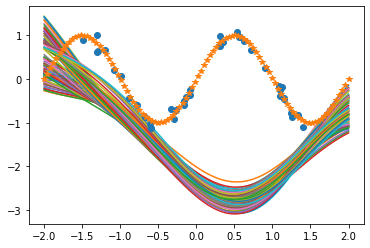

In [6]:
num_training = 40
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=30, n_gp=[1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 400
num_samples = 100
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")

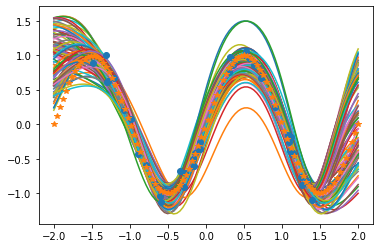

In [7]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]),"*")
# plt.savefig('sin-2-layers.png')

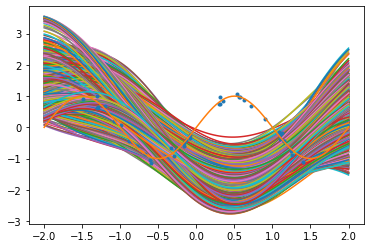

In [8]:
num_mixing_epoches = 0
num_samples = 1000
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

# Cyclical stepsize schedule - 2-layer DGPs

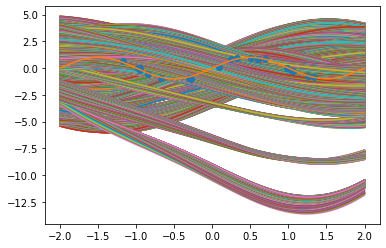

In [6]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=30, n_gp=[1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 0
num_cyclical_epoches = 50000
eta = 0.1
M = 200
iteration_per_cycle = num_cyclical_epoches // M

out_samples = []
for epoch in range(num_mixing_epoches + num_cyclical_epoches):
    if epoch < num_mixing_epoches:
        lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.25)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        lr = model.adjust_cyclical_learning_rate(epoch - num_mixing_epoches, num_cyclical_epoches, M=M, lr_0=0.1)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        if (epoch-num_mixing_epoches)%(iteration_per_cycle) >= iteration_per_cycle - 101: #10 samples
            out = model.feed_forward_all_layers(X_test)
            out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

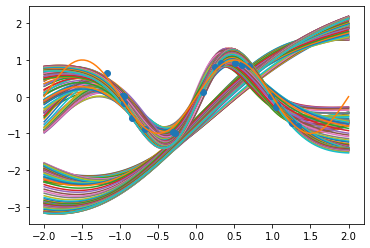

In [31]:
sample_index = [i+1000 for i in range(100)]
plt.plot(X_test, out_hid_list[:,sample_index])
plt.plot(X_test, out_list[:,sample_index])
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))
plt.savefig("sin-2-layer-mode-1.png")

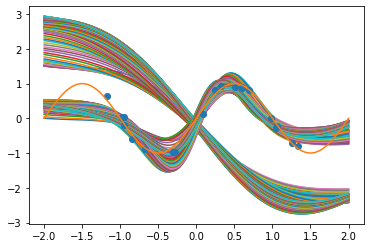

In [32]:
sample_index = [i+10000 for i in range(100)]
plt.plot(X_test, out_hid_list[:,sample_index])
plt.plot(X_test, out_list[:,sample_index])
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))
plt.savefig("sin-2-layer-mode-2.png")

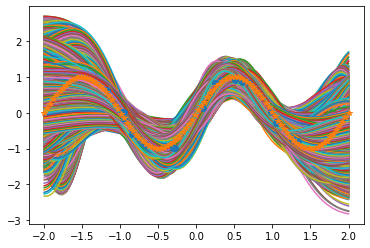

In [7]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")
# plt.savefig('sin-2-layers.png')

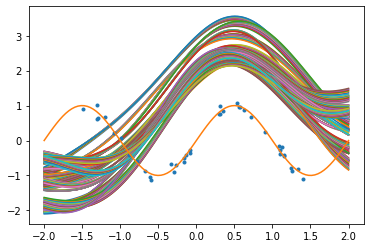

In [32]:
num_mixing_epoches = 0
num_cyclical_epoches = 1000
eta = 0.1
M = 20
iteration_per_cycle = num_cyclical_epoches // M

out_samples = []
for epoch in range(num_mixing_epoches + num_cyclical_epoches):
    if epoch < num_mixing_epoches:
        lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        lr = model.adjust_cyclical_learning_rate(epoch - num_mixing_epoches, num_cyclical_epoches, M=M, lr_0=0.1)
#         print(f"at epoch:{epoch}, learning rate:{lr}")
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        if (epoch-num_mixing_epoches)%(iteration_per_cycle) >= iteration_per_cycle - 11: #10 samples
            out = model.feed_forward_all_layers(X_test)
            out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

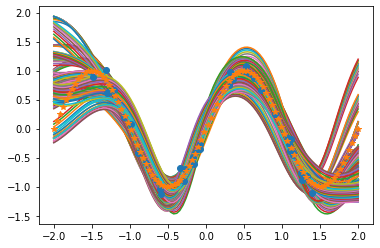

In [33]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")
# plt.savefig('sin-2-layers.png')

layer-1 $\Rightarrow$ layer-2

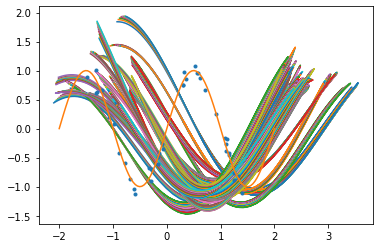

In [34]:
plt.plot(out_hid_list, out_list)
plt.plot(X_train[:,0], Y_train[:,0], ".")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]))

# 3-layer DGPs

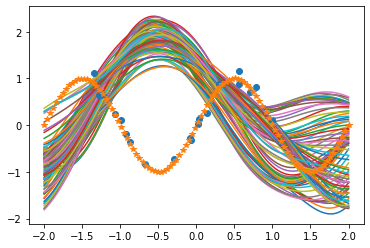

In [6]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=3, n_rf=30, n_gp=[1,1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 10000
num_samples = 100
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_hid_2_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_hid_2 = sample[1]
    out_hid_2_list.append(out_hid_2)
    out = sample[2]
    out_list.append(out)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_hid_2_list = tf.concat(out_hid_2_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")

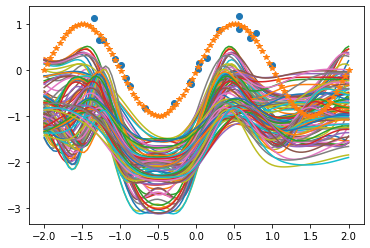

In [8]:
plt.plot(X_test, out_hid_2_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")

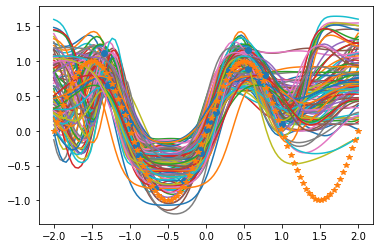

In [7]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")

# 4-layer DGPs
**increase the number of layers, showing pathology of "Avoiding Pathologies in Very Deep Networks(AISTATS 2014)"**

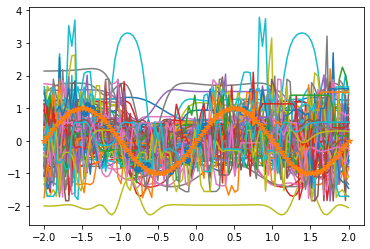

In [9]:
num_training = 20
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_sin_data(num_training, num_testing, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=4, n_rf=30, n_gp=[1,1,1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 10000
num_samples = 100
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_list = []
for sample in out_samples:
    out = sample[-1]
    out_list.append(out)

out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
plt.plot(X_test[:,0], np.sin(np.pi * X_test[:,0]), "*")